In [20]:
import pandas as pd
import os
import glob
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
# import argparse

In [3]:
# parser = argparse.ArgumentParser()

# parser.add_argument('--cancer_types', nargs="+", type=str,
#                     help='which cancer types to analyze', required=True)

In [8]:
# config = parser.parse_args("--cancer_types Skin-Melanoma".split())
# cancer_types = config.cancer_types

In [3]:
def plot_dendrogram(model, plot_title, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    figure(figsize=(30, 28))
    plt.title(plot_title)
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    plt.xticks(fontsize=10)
    plt.show()

In [4]:
def save_clustered_datafiles(model, data, cancer_type, distance_threshold, linkage, affinity):
    os.makedirs("processed_data/hierarchically_clustered_mutations/", exist_ok=True)
    threshold_dir = f"processed_data/hierarchically_clustered_mutations/{cancer_type}/linkage_{linkage}_affinity_{affinity}/dist_thresh_{distance_threshold}"
    os.makedirs(threshold_dir, 
                exist_ok=True)
    for idx, label in enumerate(np.unique(model.labels_)):
        patient_cluster = data.loc[model.labels_ == label]
        patient_cluster.to_csv(f"{threshold_dir}/C{idx}.csv")
        patient_cluster.sum(axis=0).to_csv(f"{threshold_dir}/aggregated_C{idx}.csv")

In [36]:
def cluster_data_and_display_clustering(distance_threshold, mutations_df, plot_title, 
                                        save_clusters=False, affinity='euclidean', 
                                        affinity_matrix=None, linkage="ward"):
    model = AgglomerativeClustering(n_clusters=None, 
                                    distance_threshold=distance_threshold,
                                    linkage=linkage)
    if (affinity == "euclidean"):
        model = model.fit(mutations_df)
    elif (affinity == "pearson"):
        try:
            model = model.fit(affinity_matrix)
        except:
            print("affinity matrix musn't be None when affinity = 1-pearson")
    plot_dendrogram(model, 
                    plot_title,
                    truncate_mode="level", 
                    p=100, 
                    no_labels=True, 
                    color_threshold=distance_threshold,
                    above_threshold_color="black")
    if (save_clusters):
        save_clustered_datafiles(model, mutations_df, plot_title, distance_threshold, 
                                 linkage, affinity)

In [6]:
per_patient_mutations_lung_adeno = pd.read_csv("raw_dir/mutation_data/per_cancer_icgc/LUAD-US/" \
                                             "simple_somatic_mutation.open.LUAD-US.tsv", 
                                             sep="\t")

In [7]:
unique_mutations = per_patient_mutations_lung_adeno[["icgc_donor_id", "icgc_mutation_id"]].drop_duplicates()

In [8]:
chromosome_start_end = per_patient_mutations_lung_adeno[["icgc_mutation_id", 
                                                       "icgc_donor_id",
                                                       "chromosome_start",
                                                       "chromosome_end",
                                                       "chromosome"]]
chromosome_start_end = chromosome_start_end.drop_duplicates()

In [9]:
unique_mutations = unique_mutations.merge(chromosome_start_end, 
                       how="left",
                       on=["icgc_donor_id", "icgc_mutation_id"])

In [10]:
os.makedirs("processed_data/per_patient_mutations/Lung-AdenoCA", exist_ok=True)

for index, group in unique_mutations.groupby("icgc_donor_id"):
    group.to_csv(f"processed_data/per_patient_mutations/Lung-AdenoCA/{index}.csv",
                index=False)

In [54]:
# Use countOverlaps in R

In [11]:
binned_mutation_files = glob.glob('processed_data/per_patient_mutations/Lung-AdenoCA/binned_mutations*')
columns = pd.read_csv(binned_mutation_files[0]).iloc[:, 0].values
Lung_AdenoCA = pd.DataFrame(columns=columns)

In [12]:
for file in binned_mutation_files:
    patient_id = file.split("_")[-1].split(".")[0]
    patient_mutations = pd.read_csv(file)['num_mutations']
    Lung_AdenoCA.loc[patient_id] = patient_mutations.values

In [13]:
agg_mutation_df = pd.read_csv("processed_data/mut_count_data.csv", index_col=0)

In [15]:
regions_to_consider = agg_mutation_df.loc[~agg_mutation_df.isna().any(axis=1)].index.values

In [16]:
Lung_AdenoCA = Lung_AdenoCA.loc[:, regions_to_consider]

In [26]:
distance_matrix_pearson_corr = 1 - np.corrcoef(Lung_AdenoCA)

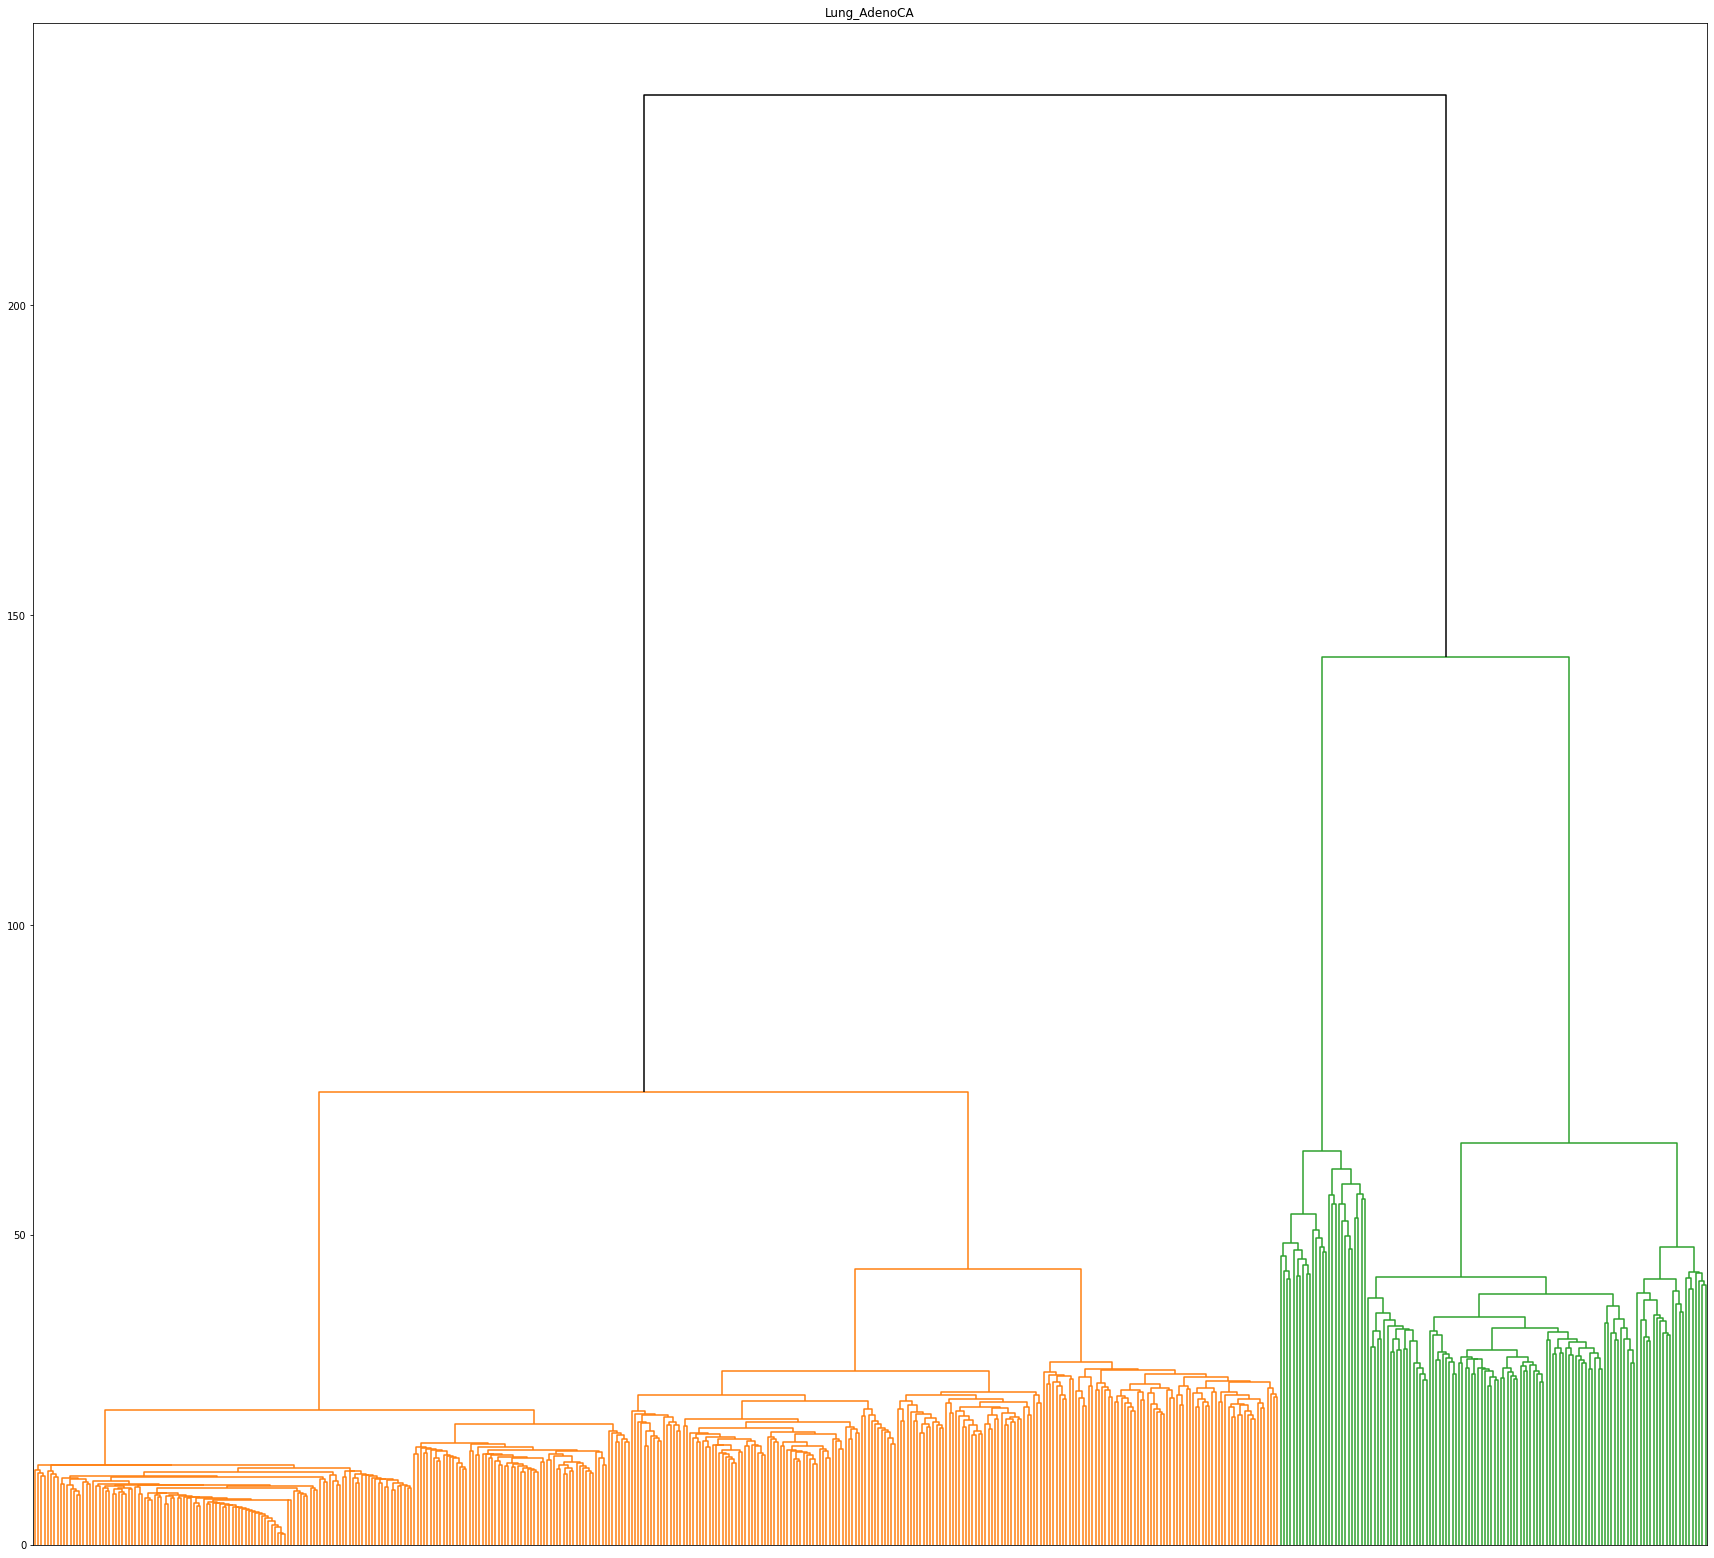

In [63]:
cluster_data_and_display_clustering(200, Lung_AdenoCA, "Lung-AdenoCA", False)

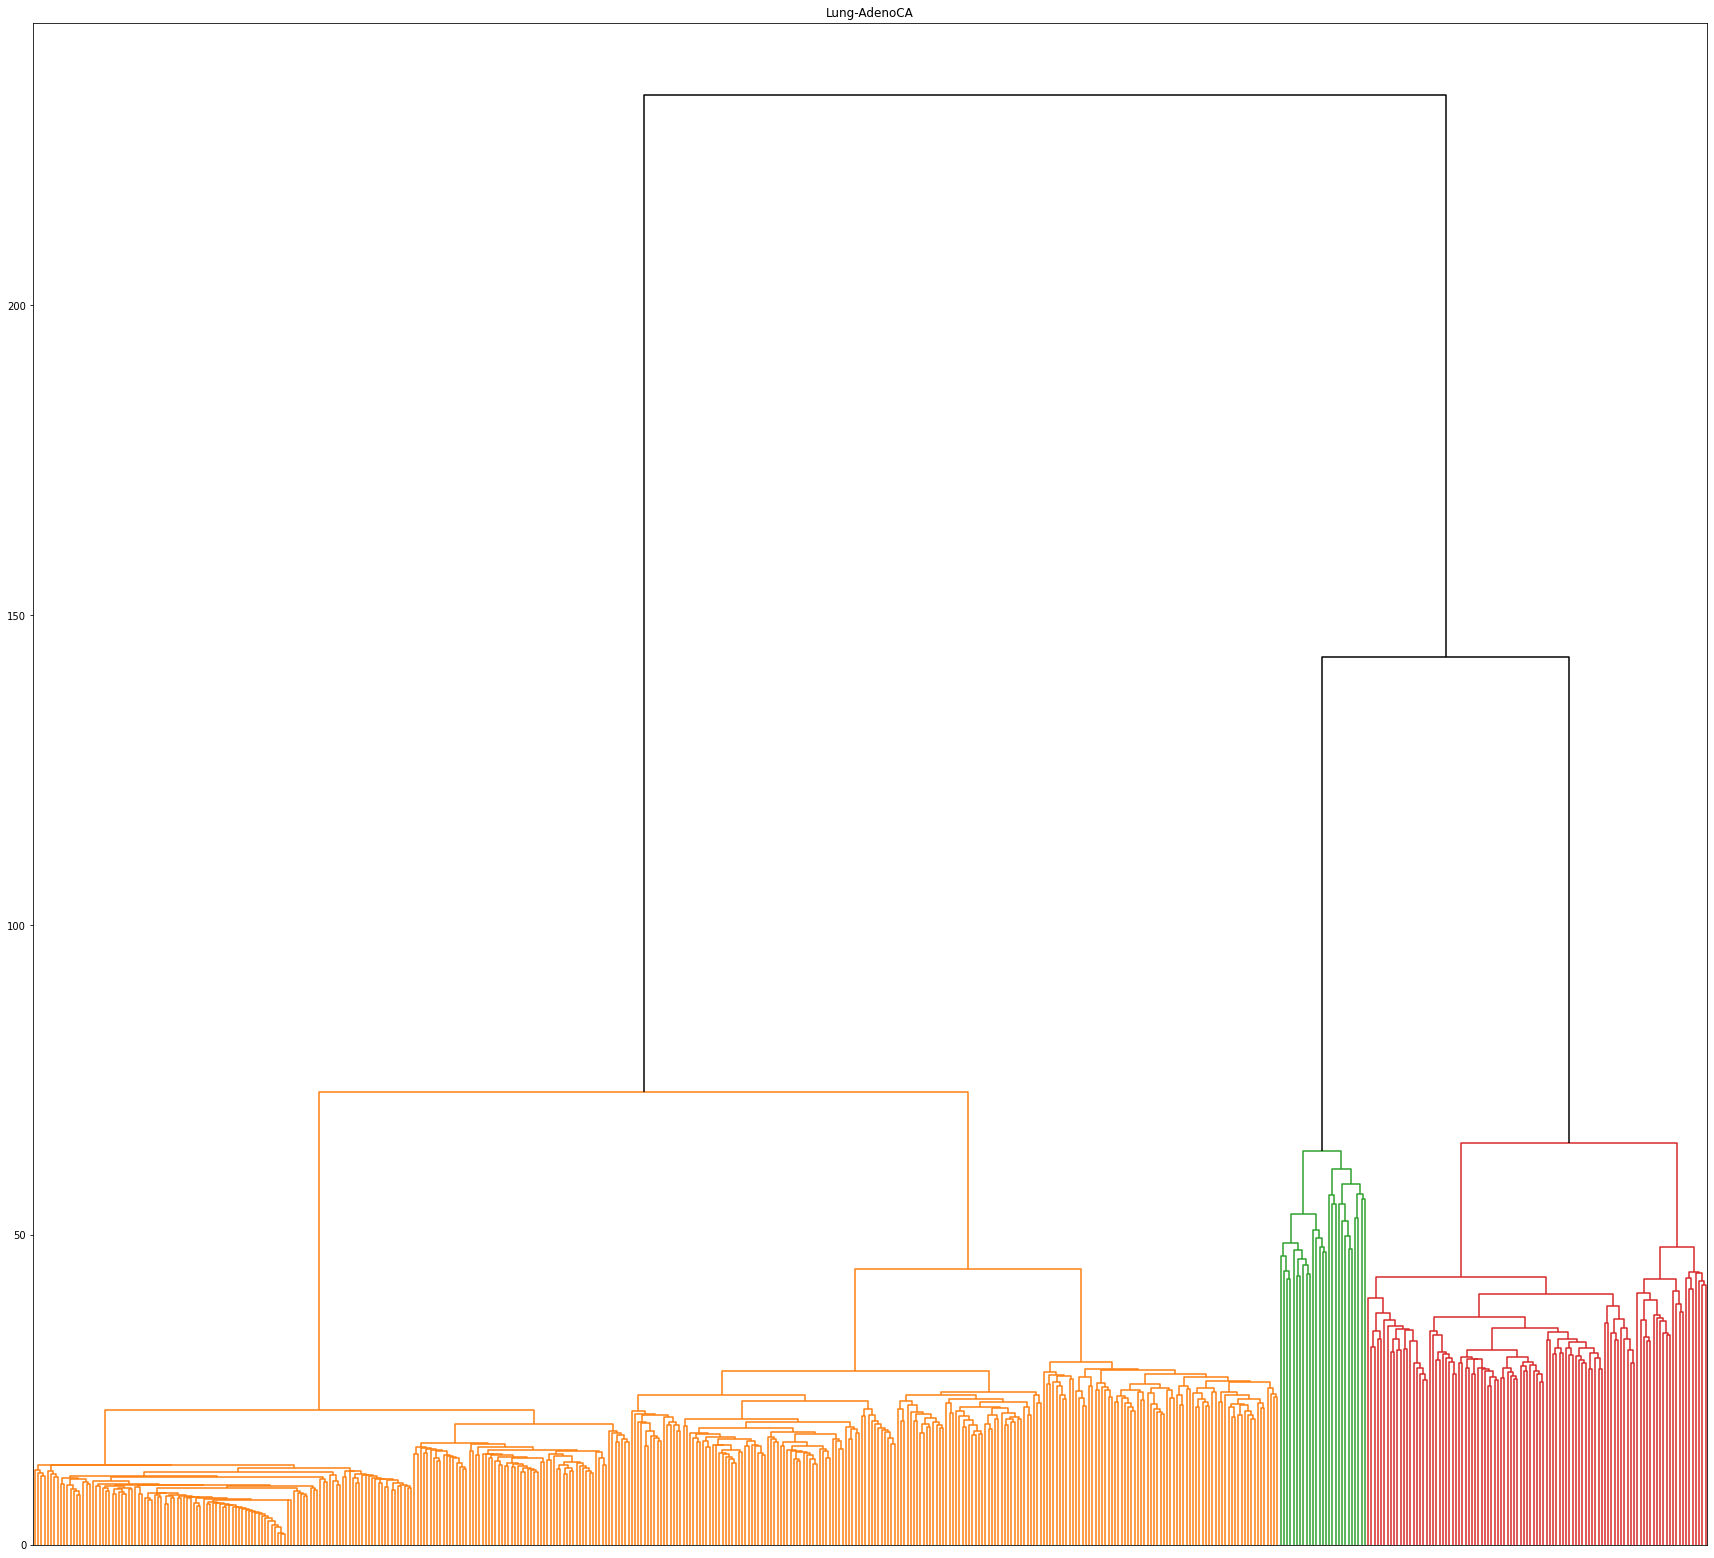

In [22]:
cluster_data_and_display_clustering(100, Lung_AdenoCA, "Lung-AdenoCA", True)

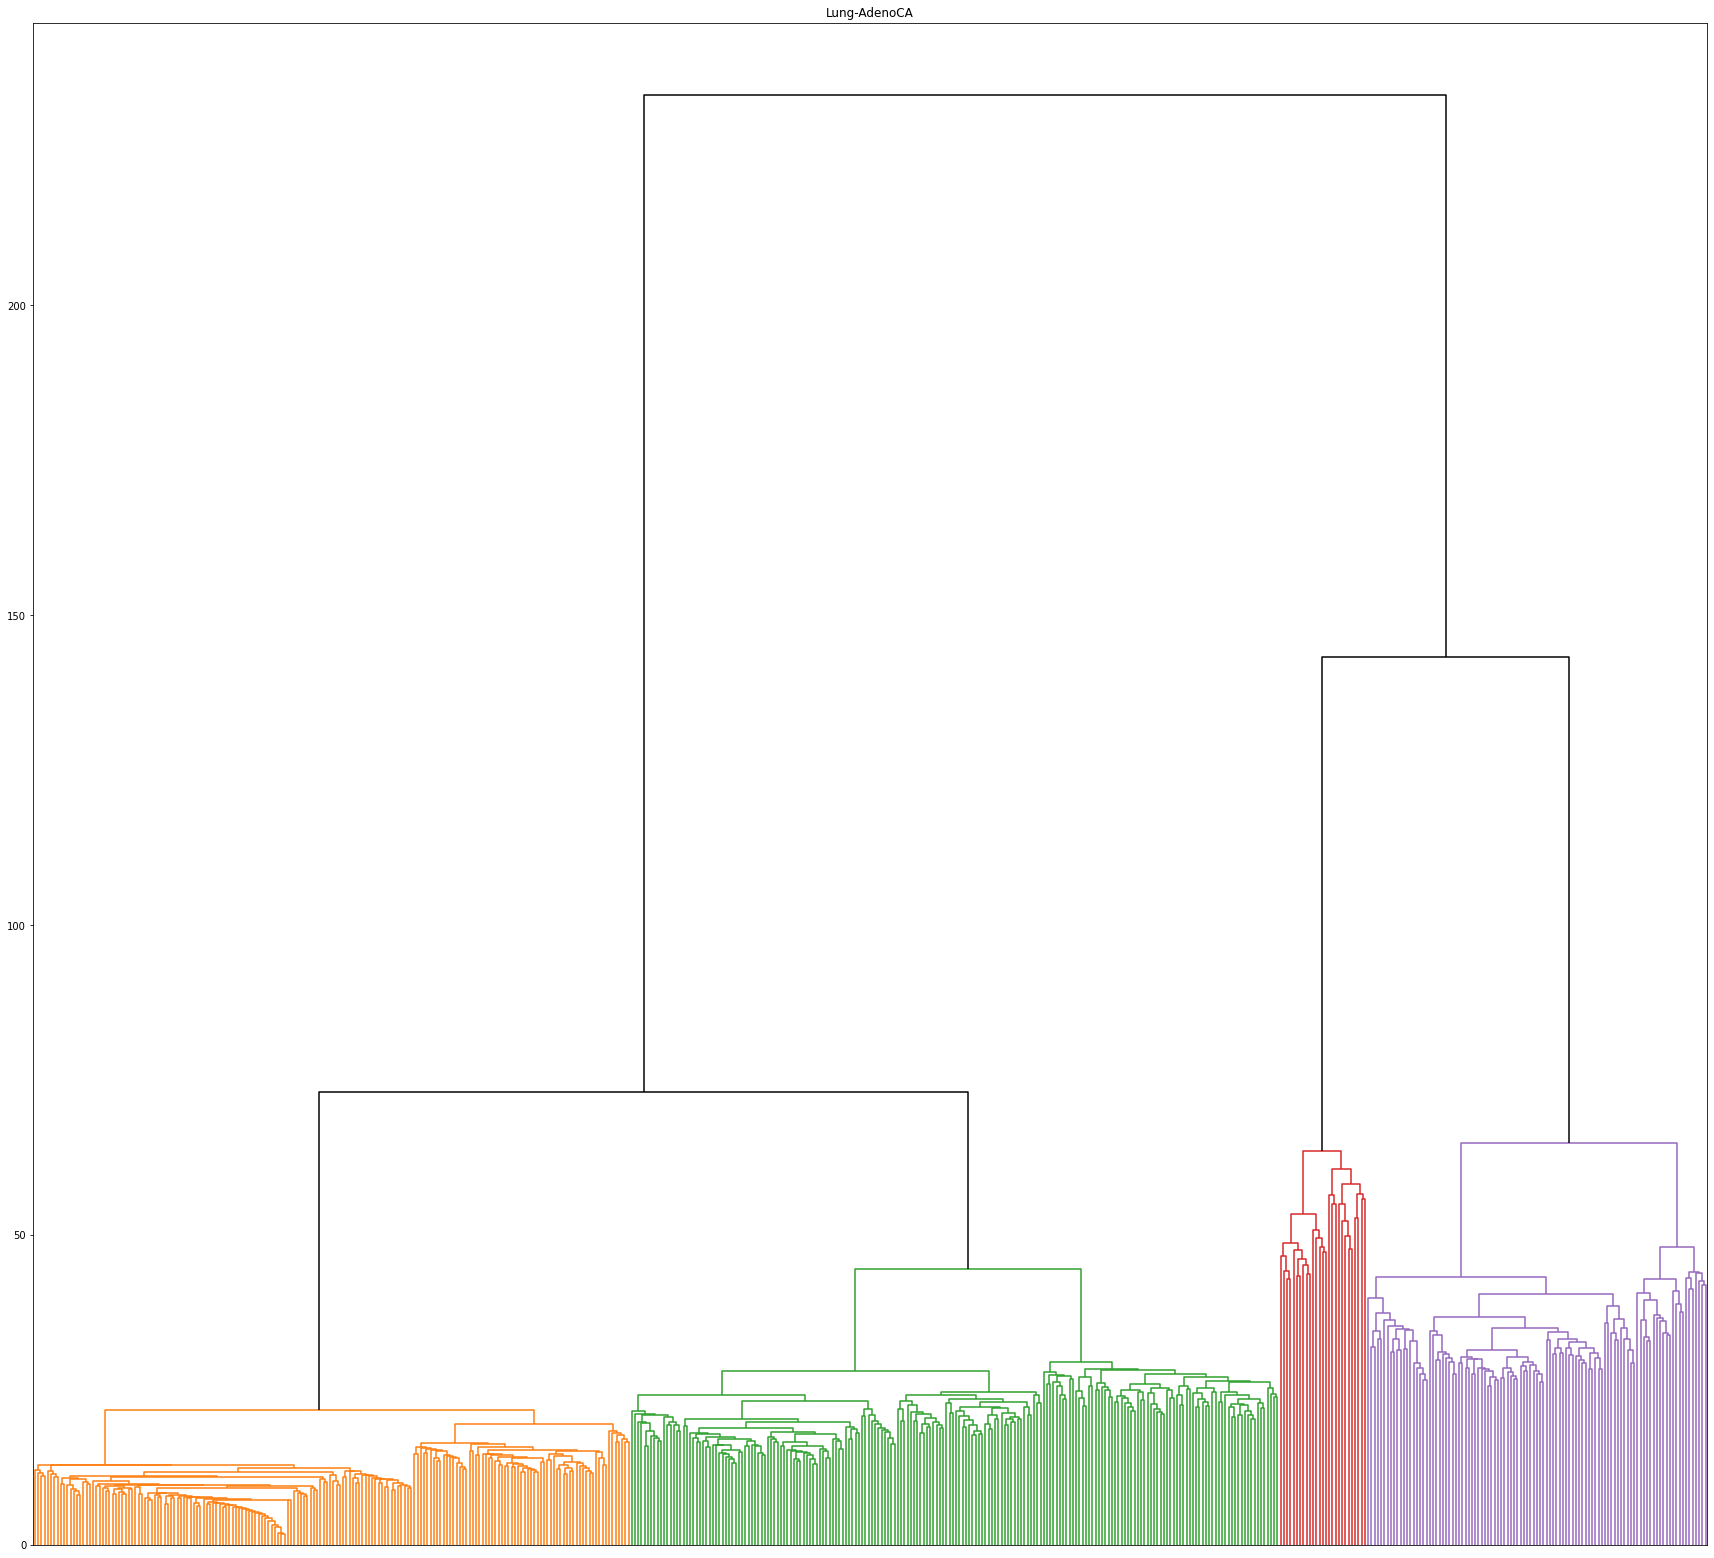

In [24]:
cluster_data_and_display_clustering(70, Lung_AdenoCA, "Lung-AdenoCA", True)

/home/mdanb/.local/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:542: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


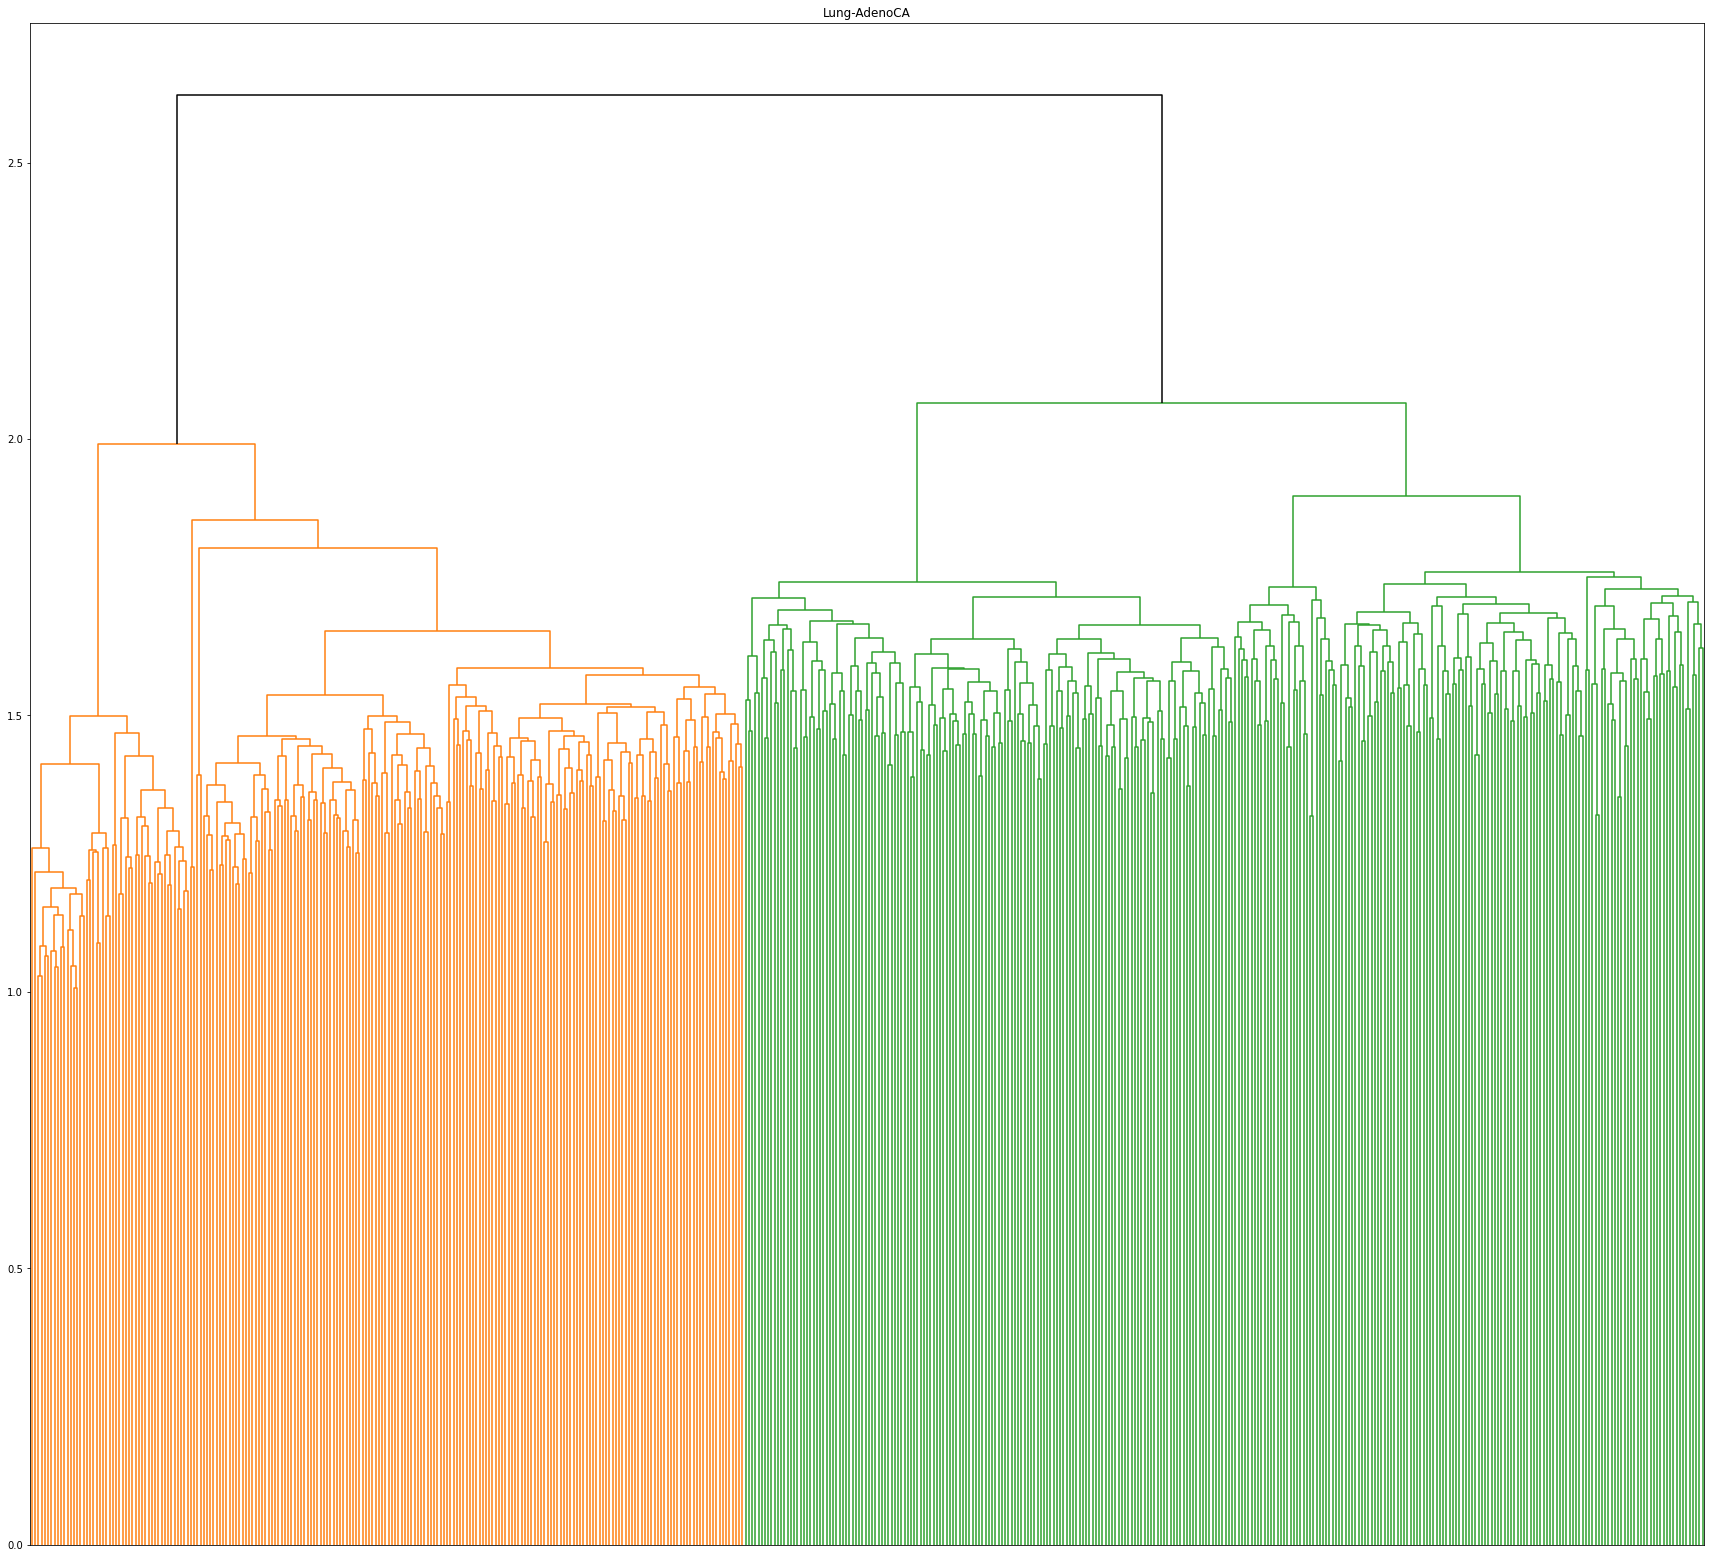

In [47]:
cluster_data_and_display_clustering(2.5, Lung_AdenoCA, "Lung-AdenoCA", False, 
                                    affinity="pearson", affinity_matrix=
                                    1 - np.corrcoef(Lung_AdenoCA), 
                                    linkage="average")

/home/mdanb/.local/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:542: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


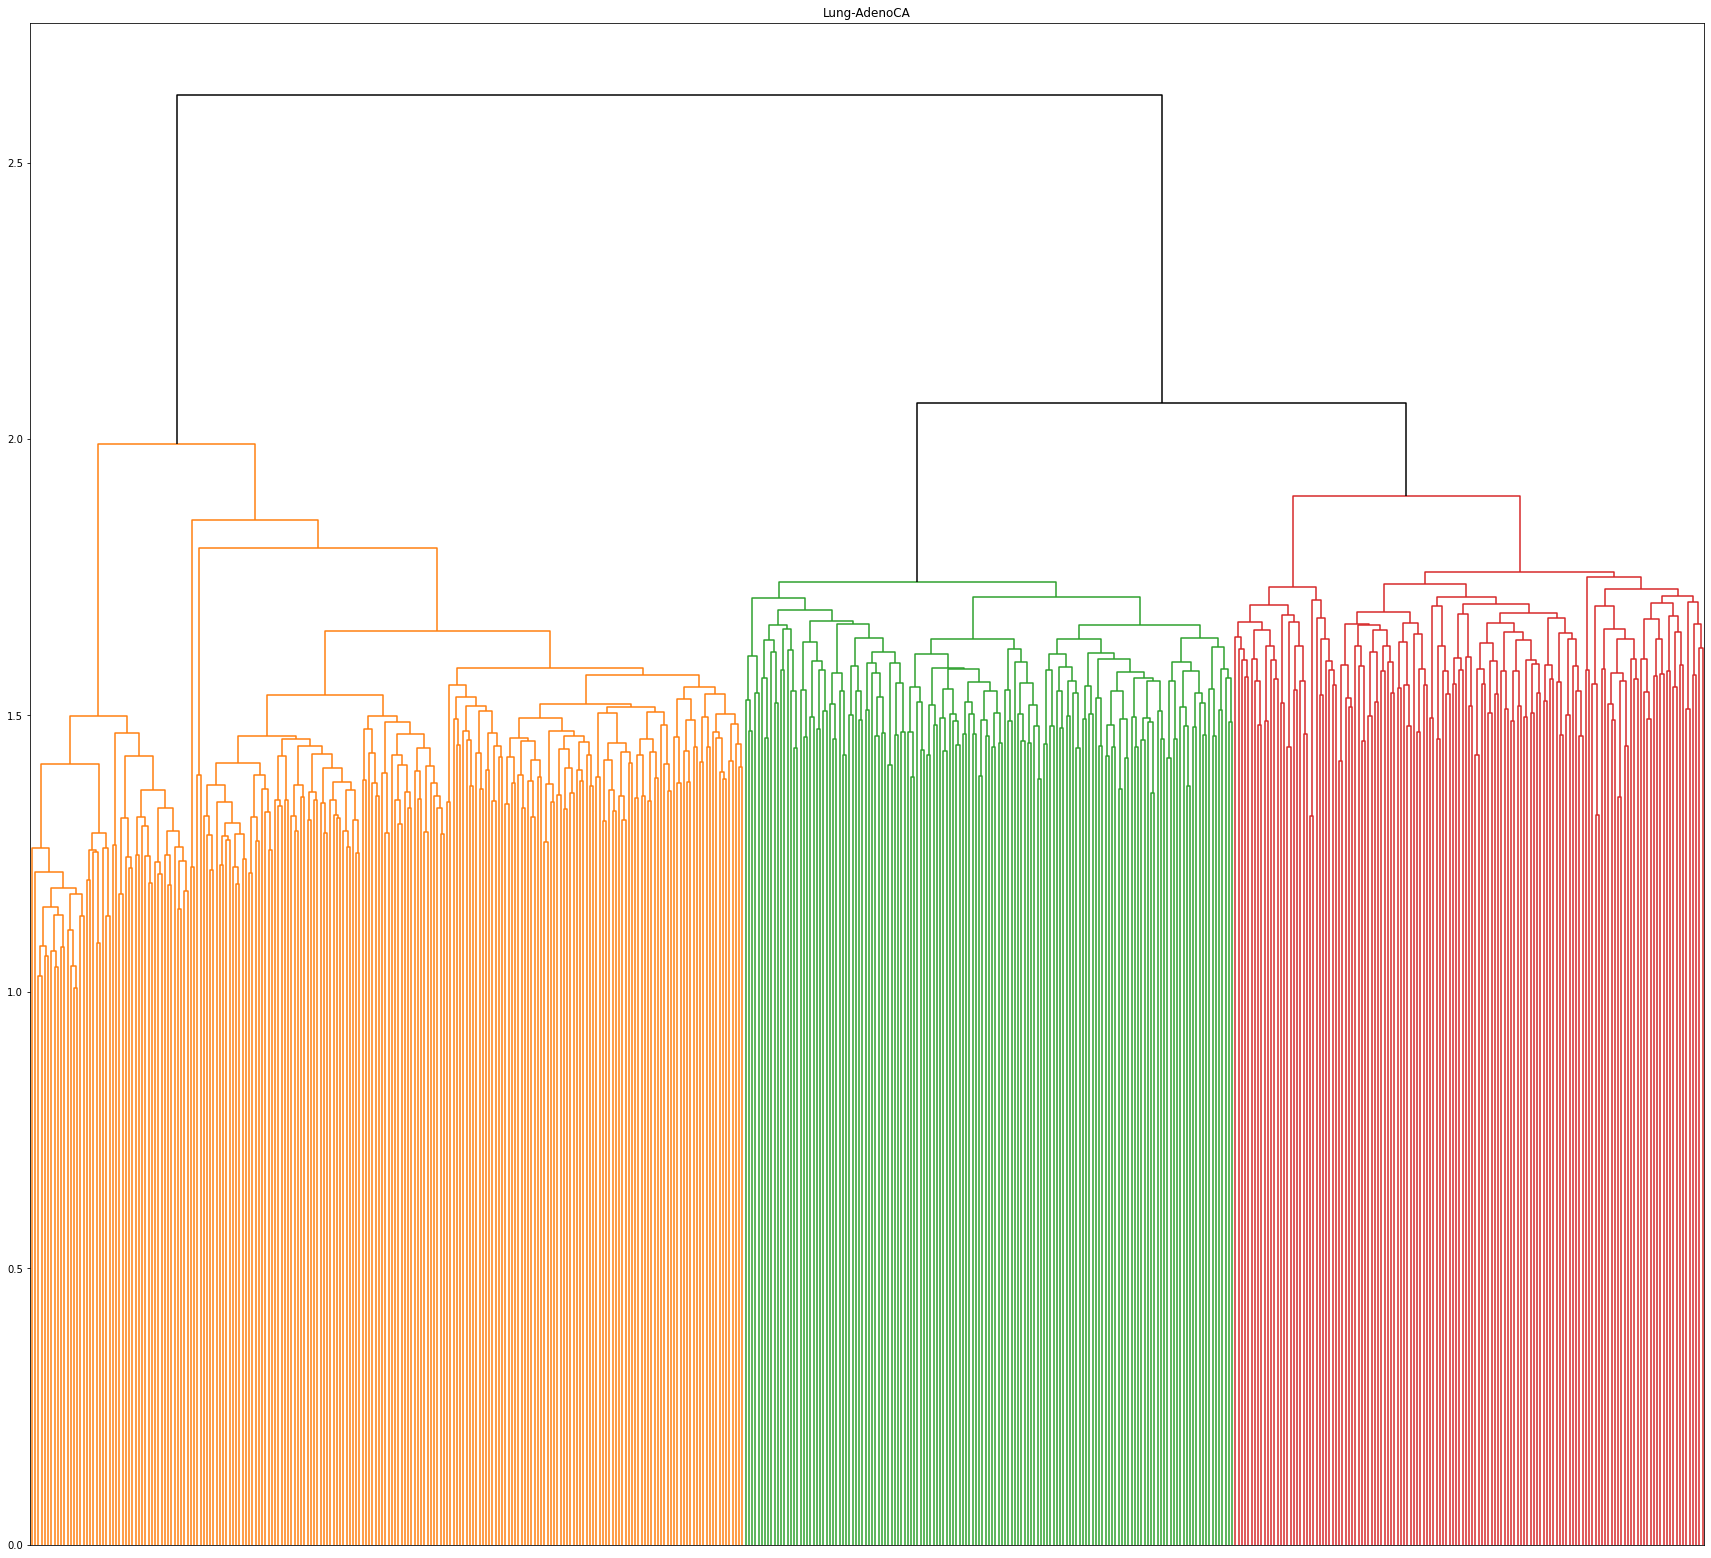

In [49]:
cluster_data_and_display_clustering(2, Lung_AdenoCA, "Lung-AdenoCA", False, 
                                    affinity="pearson", affinity_matrix=
                                    1 - np.corrcoef(Lung_AdenoCA), 
                                    linkage="average")

/home/mdanb/.local/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:542: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


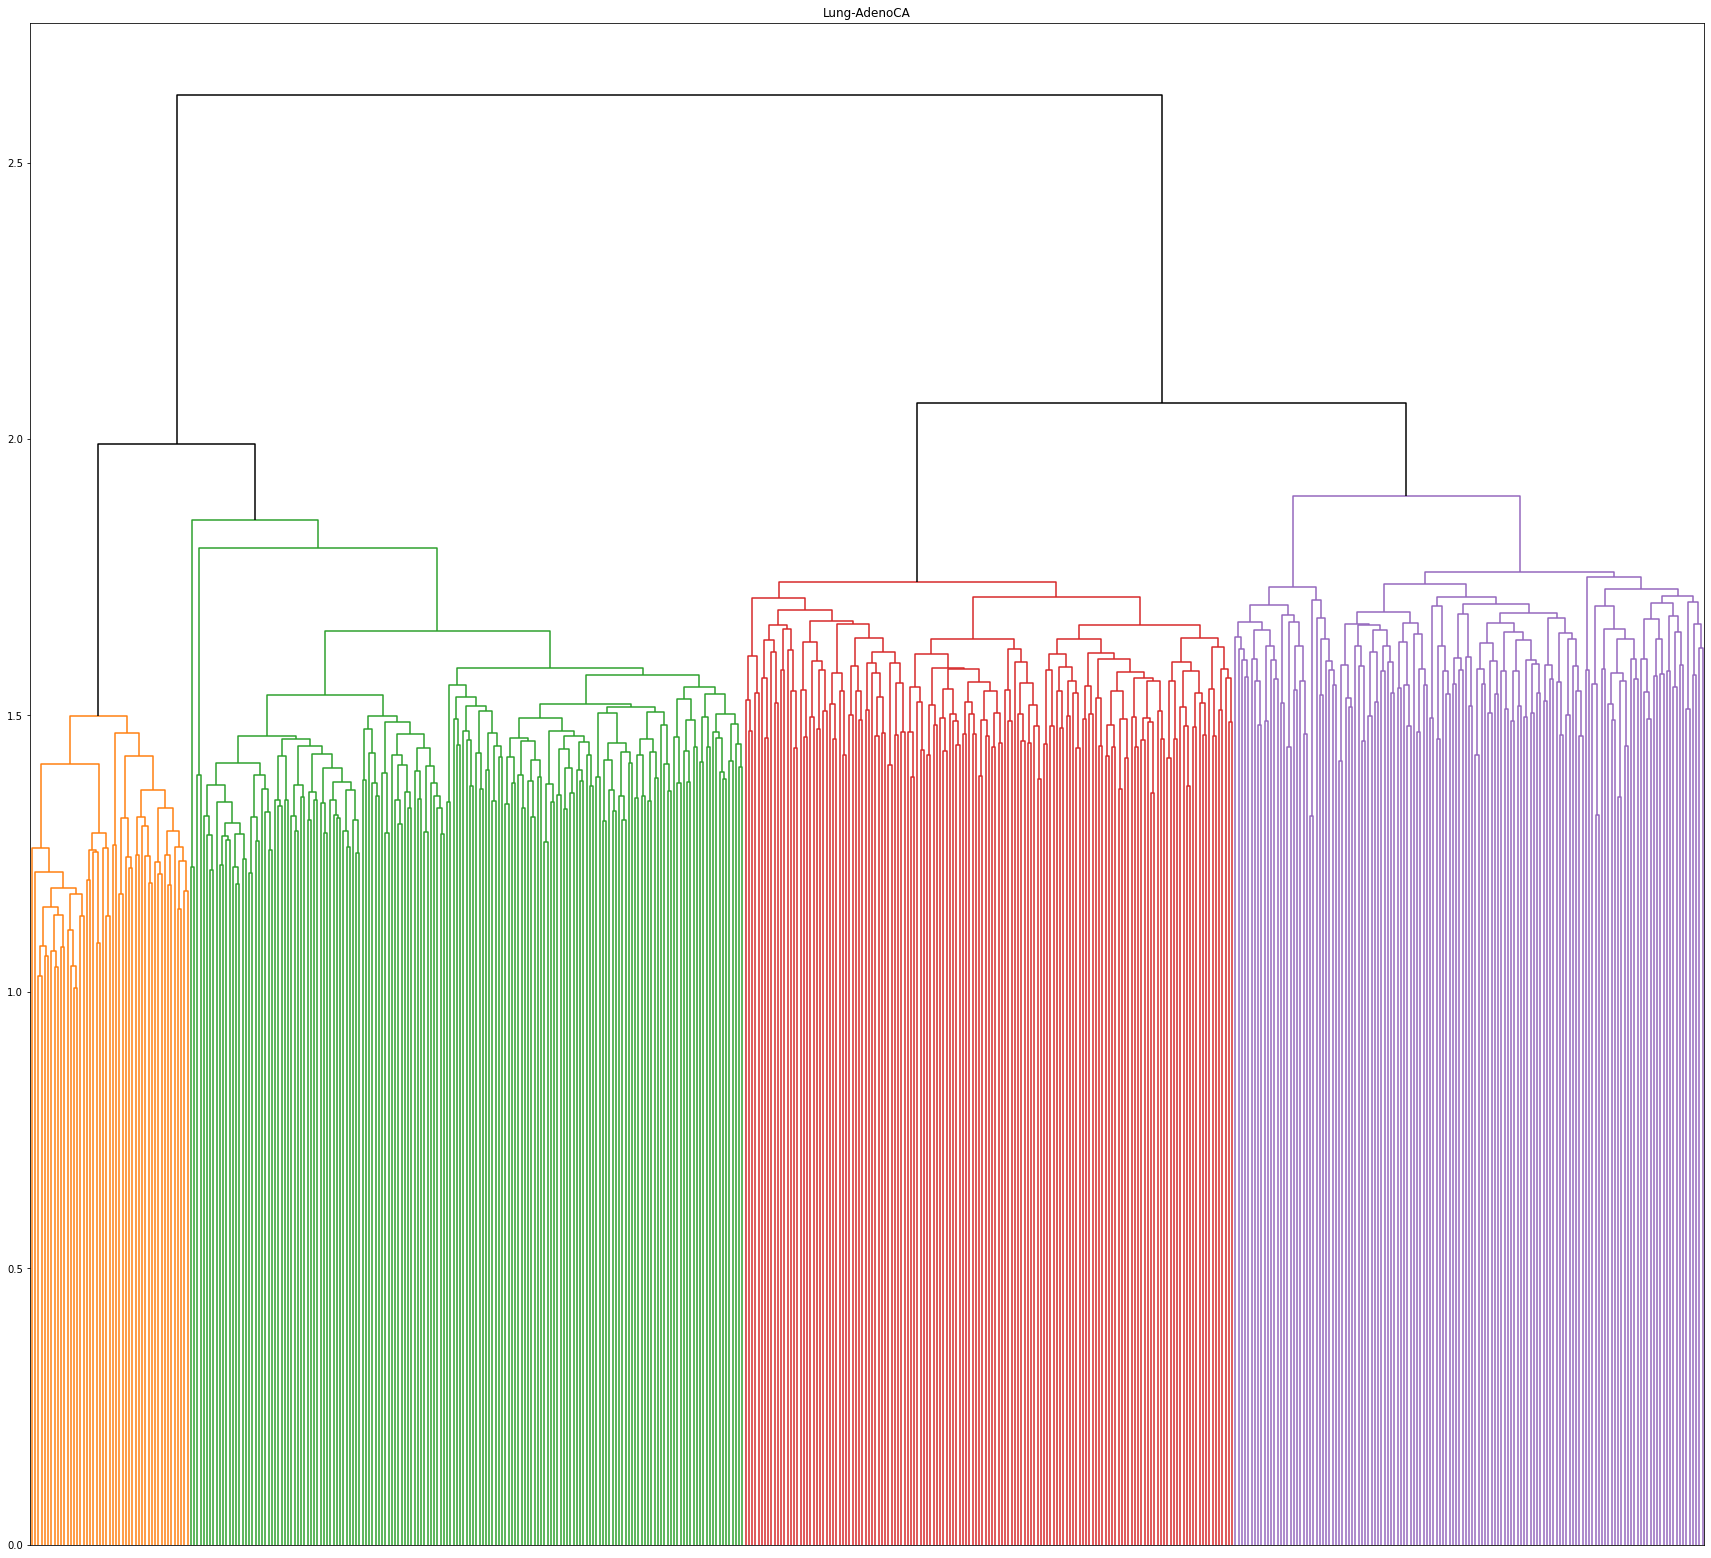

In [48]:
cluster_data_and_display_clustering(1.9, Lung_AdenoCA, "Lung-AdenoCA", False, 
                                    affinity="pearson", affinity_matrix=
                                    1 - np.corrcoef(Lung_AdenoCA), 
                                    linkage="average")